<a href="https://colab.research.google.com/github/tran-linh41214/Python_RFM-project/blob/main/Tr%E1%BA%A7n_Di%E1%BB%87u_Linh_RFM_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Python_Final_Project/ecommerce_retail.csv', encoding='latin1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


# **1. EDA**

***1.1. Explore data***


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- Decription nulls => xóa cột
- Customer ID nulls => xóa dòng
- InvoiceDate => chuyển sang type Datetime
- CustomerID => chuyển sang dạng object

In [ ]:
print('DataFrame dimension: ', data.shape)

DataFrame dimension:  (541909, 8)


In [ ]:
print(data.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


- Quantity âm là những đơn hàng cancellation => bỏ ở df tính RMF, để ở df data dể tìm insight
- Quantity quá lớn => xóa
- UnitPrice âm => xóa

***1.2. Tạo bảng thống kê đơn hủy***

In [ ]:
# Invoice chứa ký tự C ở đầu là những giao dịch bị hủy
cancelled = data['InvoiceNo'].astype(str).str.contains('C')
# Gán giá trị 0 với đơn không hủy, 1 với đơn hủy
cancelled.fillna(0, inplace=True)
cancelled = cancelled.astype(int)
cancelled.value_counts()

,count
InvoiceNo,
0,532621
1,9288


=> Số lượng đơn bị hủy là 9288

In [ ]:
data['order_cancelled'] = cancelled
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom,0


*Tính Số lượng giao dịch bị hủy và tỷ lệ phần trăm*

In [ ]:
c1 = data['order_cancelled'].value_counts()[1]
c2 = data.shape[0]
print("Number of cancelled transactions: ", c1)
print('Percent of orders cancelled: {}/{} ({:.2f}%) '.format(c1, c2, c1/c2*100))

Number of cancelled transactions:  9288
Percent of orders cancelled: 9288/541909 (1.71%) 


***1.3. Clean data, tạo df_Transaction***

In [ ]:
# Tạo một bản sao của df 'data'
df_Transaction = data.copy()

# Xóa các giao dịch bị hủy
df_Transaction = df_Transaction[df_Transaction['order_cancelled'] == 0]

# Bỏ cột Description
df_Transaction = df_Transaction.drop(columns=['Description'])

# Loại bỏ các dòng thiếu CustomerID
df_Transaction = df_Transaction.dropna(subset=['CustomerID'])

# Kiểm tra dupicates
print('Duplicate entries: {}'.format(df_Transaction.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df_Transaction.duplicated().sum()/df_Transaction.shape[0])*100),2))

# Bỏ duplicate data
df_Transaction.drop_duplicates(inplace = True)

# Đổi kiểu dữ liệu cho CustomerID và InvoiceDate
df_Transaction['CustomerID'] = df_Transaction['CustomerID'].astype(str)  # Chuyển CustomerID sang kiểu object
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d/%m/%Y %H:%M') #Chuyển InvoiceDate sang datetime

# Xóa UnitPrice và Quantity âm
df_Transaction = df_Transaction[(df_Transaction['UnitPrice'] > 0) & (df_Transaction['Quantity'] > 0)]

# Kiểm tra kết quả EDA
print(df_Transaction.head())
print(df_Transaction.describe())
print(df_Transaction.dtypes)



Duplicate entries: 5194
1% rows are duplicate.
  InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55    17850.0   
1    536365     71053         6 2010-12-01 08:26:00       3.39    17850.0   
2    536365    84406B         8 2010-12-01 08:26:00       2.75    17850.0   
3    536365    84029G         6 2010-12-01 08:26:00       3.39    17850.0   
4    536365    84029E         6 2010-12-01 08:26:00       3.39    17850.0   

          Country  order_cancelled  
0  United Kingdom                0  
1  United Kingdom                0  
2  United Kingdom                0  
3  United Kingdom                0  
4  United Kingdom                0  
            Quantity                    InvoiceDate      UnitPrice  \
count  392690.000000                         392690  392690.000000   
mean       13.118997  2011-07-10 19:12:51.826224128       3.125913   
min         1.000000            2010-12-01 08:26:00       

# **2. TÍNH RFM**

In [ ]:
# Tạo cột doanh thu
df_Transaction['Revenue'] = df_Transaction['UnitPrice'] * df_Transaction['Quantity']
# Để InvoiceDate chỉ hiển thị date
from datetime import datetime
df_Transaction["InvoiceDate"] = df_Transaction["InvoiceDate"].dt.date

import datetime as dt
last_date = max(df_Transaction.InvoiceDate) + dt.timedelta(days=1)

***2.1. Tính RFM***

In [ ]:
df_rmf = df_Transaction.groupby('CustomerID').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
df_rmf['InvoiceDate'] = df_rmf['InvoiceDate'].astype(int)

# Rename columns
df_rmf.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Revenue': 'Monetary'}, inplace=True)
df_rmf.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


***2.2. Tính RFM Score***

In [ ]:
# Tính điểm Recency (R), Frequency (F), Monetary (M)
df_rmf['R_Score'] = pd.qcut(df_rmf['Recency'], 5, labels=[5, 4, 3, 2, 1])
df_rmf['F_Score'] = pd.qcut(df_rmf['Frequency'], 5, labels=[1, 2, 3, 4, 5])
df_rmf['M_Score'] = pd.qcut(df_rmf['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Bước 2: Kết hợp các điểm df_rmf thành một chuỗi
df_rmf['RFM_Score'] = df_rmf['R_Score'].astype(str) + df_rmf['F_Score'].astype(str) + df_rmf['M_Score'].astype(str)

# Kết quả là DataFrame với các cột R_Score, F_Score, M_Score, và df_rmf_Score
print(df_rmf[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']])

     CustomerID  Recency  Frequency  Monetary RFM_Score
0       12346.0      326          1  77183.60       115
1       12347.0        3        182   4310.00       555
2       12348.0       76         31   1797.24       234
3       12349.0       19         73   1757.55       444
4       12350.0      311         17    334.40       122
...         ...      ...        ...       ...       ...
4333    18280.0      278         10    180.60       111
4334    18281.0      181          7     80.82       111
4335    18282.0        8         12    178.05       511
4336    18283.0        4        721   2045.53       554
4337    18287.0       43         70   1837.28       344

[4338 rows x 5 columns]


# **3. Segmentation**

***3.1. Load bảng segmentation***

In [ ]:
!pip install openpyxl
import io
import requests

url = 'https://docs.google.com/spreadsheets/d/1-gdRDBcGEmwyLV5FiUkAVNL42QubSMx-/export?format=xlsx'
r = requests.get(url)
r.raise_for_status()

df_segment = pd.read_excel(io.BytesIO(r.content), engine='openpyxl')

In [ ]:
# Chuyển đổi cột `RFM Score` thành các hàng riêng biệt
df_segment['RFM_Score'] = df_segment['RFM_Score'].str.split(',')
df_segment = df_segment.explode('RFM_Score').reset_index(drop=True)

# Xóa khoảng trắng thừa trong 'RFM Score' nếu có
df_segment['RFM_Score'] = df_segment['RFM_Score'].str.strip()

# Kết quả
print(df_segment)

            Segment RFM_Score
0         Champions       555
1         Champions       554
2         Champions       544
3         Champions       545
4         Champions       454
..              ...       ...
120  Lost customers       112
121  Lost customers       121
122  Lost customers       131
123  Lost customers       141
124  Lost customers       151

[125 rows x 2 columns]


***3.2. Merge bảng Segmentation và bảng RFM***

In [ ]:
# Merge hai bảng dựa trên cột "RFM_Score"
df_user = pd.merge(df_rmf, df_segment, on='RFM_Score', how='left')

print(df_user.head())

  CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
0    12346.0      326          1  77183.60       1       1       5       115   
1    12347.0        3        182   4310.00       5       5       5       555   
2    12348.0       76         31   1797.24       2       3       4       234   
3    12349.0       19         73   1757.55       4       4       4       444   
4    12350.0      311         17    334.40       1       2       2       122   

                 Segment  
0       Cannot Lose Them  
1              Champions  
2                At Risk  
3                  Loyal  
4  Hibernating customers  


In [ ]:
# Tính số lượng khách hàng trong mỗi segment
df_describe = df_user.groupby('Segment').agg({'CustomerID': lambda x: len(x)}).reset_index()

df_describe.rename(columns={'CustomerID': 'Count'}, inplace=True)
df_describe['percent'] = (df_describe['Count'] / df_describe['Count'].sum()) * 100
df_describe['percent'] = df_describe['percent'].round(1)

print(df_describe)

,Segment,Count,percent
0,About To Sleep,191,4.4
1,At Risk,424,9.8
2,Cannot Lose Them,92,2.1
3,Champions,796,18.3
4,Hibernating customers,802,18.5
5,Lost customers,433,10.0
6,Loyal,416,9.6
7,Need Attention,229,5.3
8,New Customers,308,7.1
9,Potential Loyalist,512,11.8




| Phân đoạn               | Đặc điểm                                                                                   | Khuyến nghị                                                                                          |
|-------------------------|-------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Champions**           | Mua gần đây, mua thường xuyên và chi tiêu nhiều nhất                                    | Tặng quà, tặng các chương trình ưu đãi. Dùng thử sản phẩm mới miễn phí. Khuyến khích họ quảng bá thương hiệu. |
| **Loyal**               | Chi tiêu khá nhiều và mua thường xuyên. Phản hồi tốt với các chương trình khuyến mãi.     | Đề xuất các sản phẩm giá trị cao hơn. Thu thập đánh giá về sản phầm. Kết nối với họ thường xuyên.                 |
| **Potential Loyalist**  | Khách hàng mới, mua nhiều và mua hơn một lần.                                             | Đưa ra các chương trình thành viên/khách hàng trung thành, giới thiệu sản phẩm khác.                   |
| **New Customers**       | Vừa mới mua, nhưng không thường xuyên.                                                    | Cung cấp hỗ trợ ban đầu, giúp họ mua hàng thành công ngay từ lần đầu.               |
| **Promising**           | Người mua gần đây, nhưng chưa chi nhiều.                                             | Xây dựng nhận diện thương hiệu, cung cấp các bản dùng thử miễn phí.                                  |
| **Need Attention**      | Giá trị Recency, Frequency và Monetary trên trung bình, nhưng chưa mua thường xuyên.      | Đưa ra các ưu đãi có thời hạn dựa trên lịch sử mua hàng trước đây. Khuyến khích khách hàng mua hàng trở lại       |
| **About to Sleep**      | Giá trị Recency, Frequency và Monetary dưới trung bình, có thể sẽ mất nếu không kích hoạt. | Giới thiệu sản phẩm phổ biến hoặc ưu đãi giảm giá. Kết nối lại với họ.   |
| **At Risk**             | Chi tiêu nhiều và mua hàng thường xuyên, nhưng đã lâu không mua.                         | Gửi email, zalo OA,... cá nhân hóa để tái kết nối, đề nghị gia hạn.                    |
| **Cannot Lose Them**    | Đã mua với số lượng lớn và thường xuyên, nhưng lâu rồi không quay lại.                    | Thu hút lại bằng các sản phẩm mới hoặc gia hạn, không để mất khách hàng vào tay đối thủ.                     |
| **Hibernating customers** | Mua hàng đã lâu, ít chi tiêu và ít đơn hàng.                                           | Đề nghị các sản phẩm phù hợp khác và ưu đãi đặc biệt. Xây dựng lại giá trị thương hiệu.             |
| **Lost customers**      | Giá trị Recency, Frequency và Monetary thấp nhất.                                        | Khơi gợi sự quan tâm lại bằng các chiến dịch tiếp cận, nếu không có thể bỏ qua.                     |



# **4. Visualization**

***4.1. Histogram distribution***

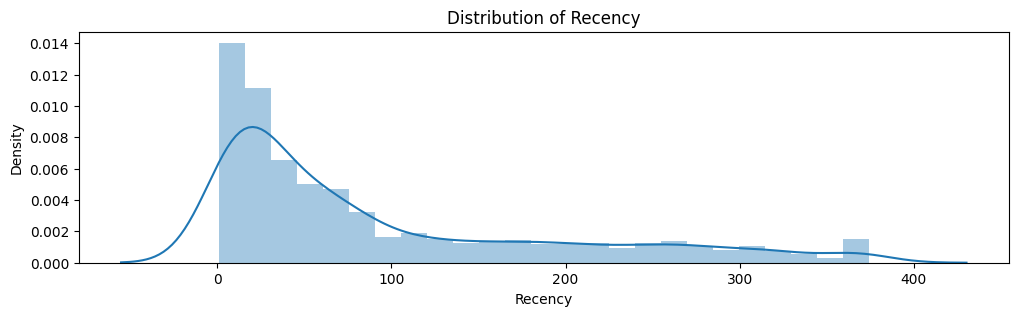

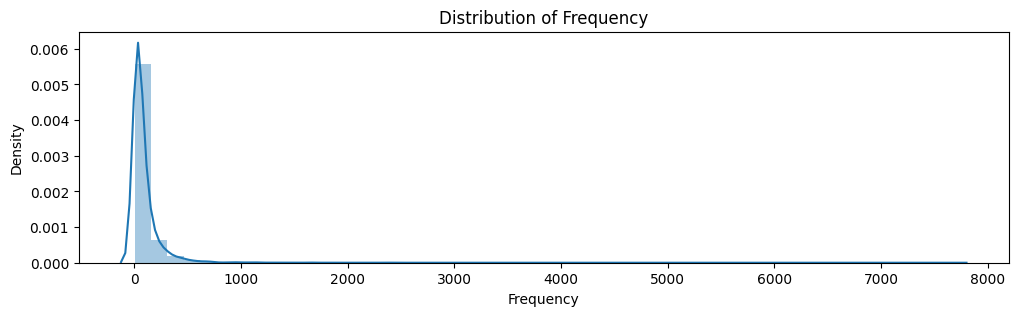

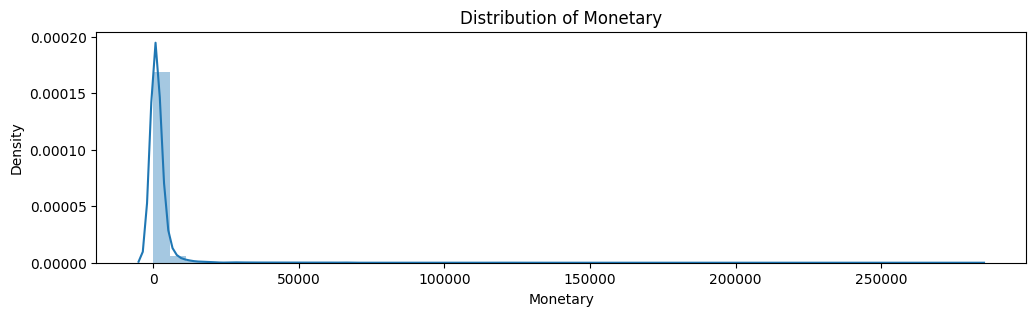

In [ ]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rmf[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

***4.2. Treemap***

*Phân khúc theo khách hàng*

In [ ]:
# Nhóm theo 'Segment' để đếm số lượng khách hàng trong từng phân khúc
grp_customer = df_user.groupby('Segment').size().reset_index(name='Cust_count')
# Tính tỉ lệ phần trăm số lượng khách hàng trong mỗi phân khúc
grp_customer['Count_share'] = grp_customer['Cust_count'] / grp_customer['Cust_count'].sum()

*Phân khúc theo tổng doanh thu (Total_sales)*

In [ ]:
# Nhóm theo 'Segment' và tính tổng doanh thu (Monetary) trong từng phân khúc
grp_sales = df_user.groupby('Segment')['Monetary'].sum().reset_index(name='Total_sales')
# Tính tỉ lệ phần trăm doanh thu trong mỗi phân khúc
grp_sales['Sales_share'] = grp_sales['Total_sales'] / grp_sales['Total_sales'].sum()

*Treemap cho Phân Khúc Khách Hàng*

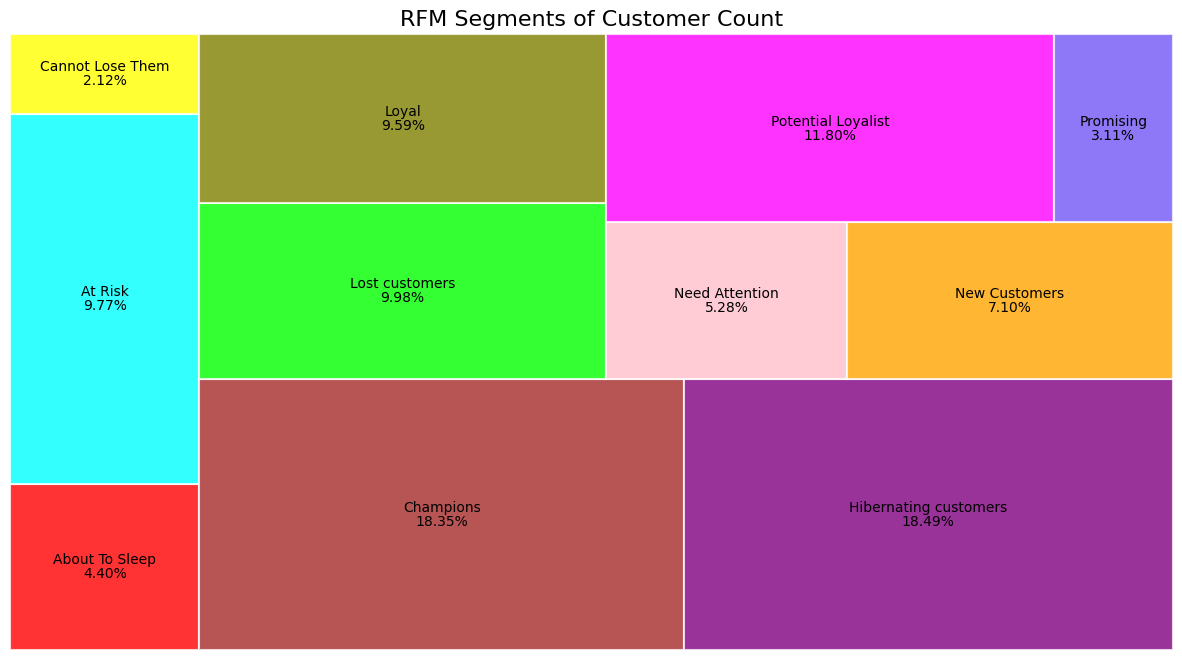

In [ ]:
# Palette color
colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#FFC0CB', '#FFA500', '#FF00FF', '#7356F6']

# Tạo biểu đồ treemap cho số lượng khách hàng trong từng phân khúc
fig, ax = plt.subplots(1, figsize=(15, 8))
squarify.plot(sizes=grp_customer['Cust_count'],
              label=grp_customer['Segment'],
              value=[f'{x*100:.2f}%' for x in grp_customer['Count_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

*Treemap cho Tổng Doanh Thu*

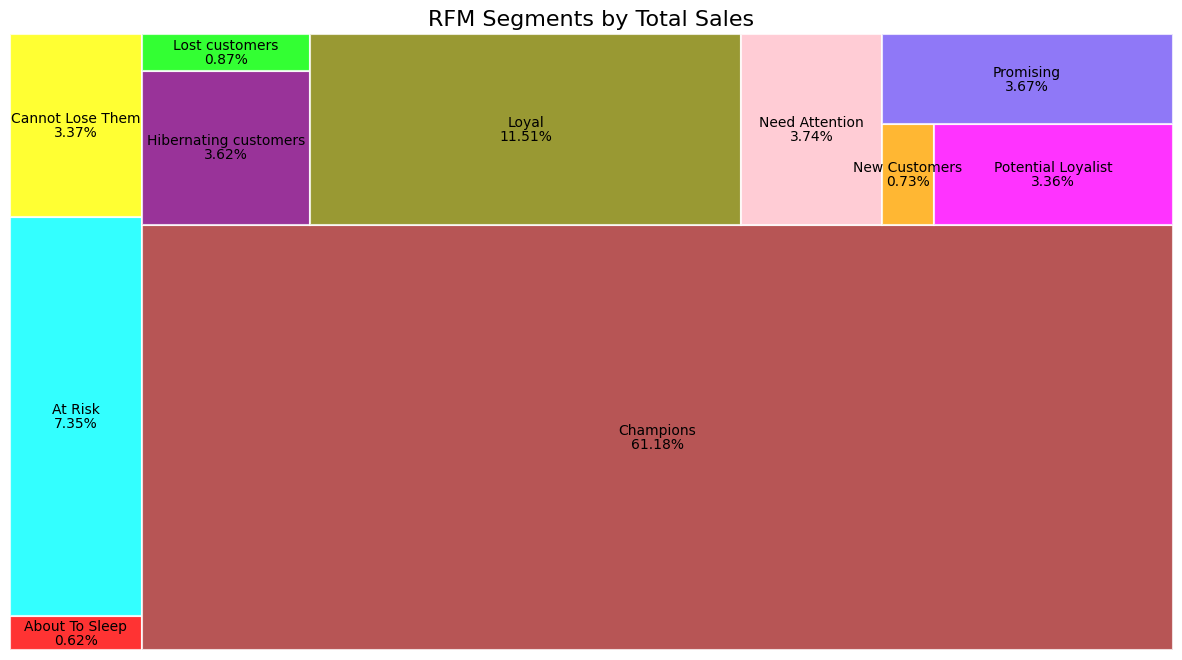

In [ ]:
# Tạo biểu đồ treemap cho tổng doanh thu
fig, ax = plt.subplots(1, figsize=(15, 8))
squarify.plot(sizes=grp_sales['Total_sales'],
              label=grp_sales['Segment'],
              value=[f'{x*100:.2f}%' for x in grp_sales['Sales_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('RFM Segments by Total Sales', fontsize=16)
plt.axis('off')
plt.show()

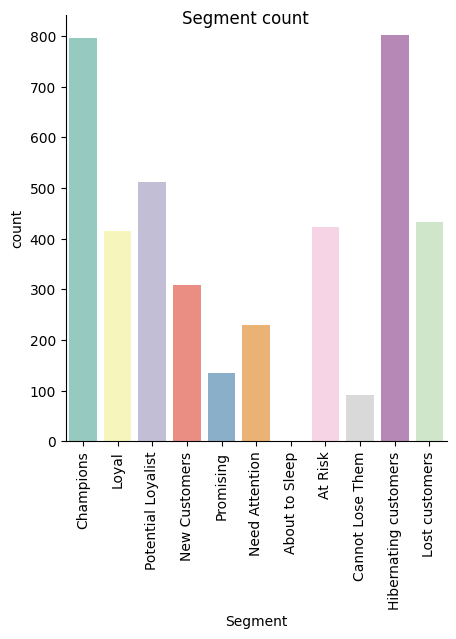

In [ ]:


#Biểu đồ cột
category_order = ['Champions','Loyal','Potential Loyalist','New Customers','Promising','Need Attention','About to Sleep','At Risk','Cannot Lose Them','Hibernating customers','Lost customers']

g = sns.catplot(x="Segment",data=df_user, kind="count", palette="Set3", order=category_order)
g.fig.suptitle("Segment count")
g.set_xticklabels(rotation=90)



***4.3. Scatter plots***

*Scatter plots mối quan hệ giữa các chỉ số của 1 khách hàng*

In [ ]:
df_rel = df_user.copy()

# Loại bỏ outliers
y1 = df_rel['Frequency']
size = df_rel.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = df_rel[~removed_outliers].index
df_rel.drop(index_names, inplace=True)

# Loại bỏ outliers
y2 = df_rel['Recency']
size = df_rel.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = df_rel[~removed_outliers].index
df_rel.drop(index_names, inplace=True)

# Loại bỏ outliers
y3 = df_rel['Monetary']
size = df_rel.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = df_rel[~removed_outliers].index
df_rel.drop(index_names, inplace=True)

3943/4338 data points remain.
3581/3943 data points remain.
3223/3581 data points remain.


*Recency & Frequency*

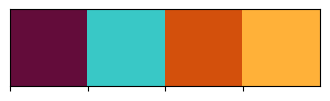

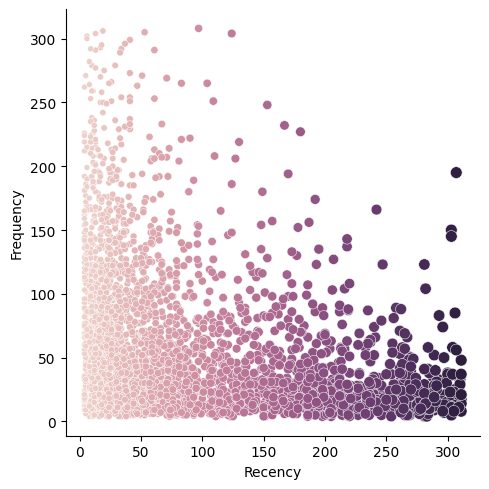

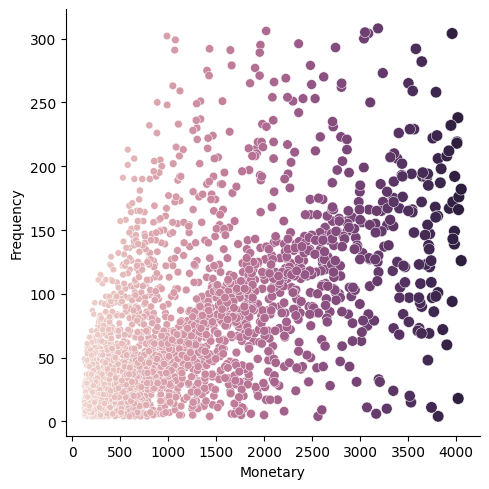

In [ ]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

# Recency vs Frequency
sns.relplot(x='Recency', y='Frequency', data=df_rel, kind='scatter', size="Recency", hue="Recency", legend=False)
# Frequency vs Monetary
sns.relplot(x='Monetary', y='Frequency', data=df_rel, kind='scatter', size="Monetary", hue="Monetary", legend=False)

plt.show()